Using an FFT package of your choice, find the power spectrum of the time series provided in the file 
http://th-www.if.uj.edu.pl/zfs/gora/timeseries21/assgn2.txt
and plot it on a log-log scale. The noise spectrum is supposed to be flat. Set the actual sampling time as the time unit so that the Nyquist frequency is 1/2. Construct the Wiener filter, apply it to the data and plot the filtered signal. You may try using various window functions. There are 4096 points in the data file. Try doing the same using the first 2048 or 1024 data points only.

The noise background is supposed to have the power spectrum:
$$N(f) = \frac{\alpha^2}{1+ \beta^2 - 2\beta \cos \left( 2\pi \frac{f}{\tilde f}\right)}$$

where $\tilde{f}$ sets the scale so that Nyquist frequency equals $\frac{1}{2}$.$ \alpha^2$ and $\beta$ are the parameters that actuallyneed  to  be  fitted.   The  fit  may  be  quite  rough,  do  not  waste  too  much  time  on  fine-tuning  theseparameters

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.fft import fft, ifft, fftfreq

import scipy as sp
from scipy.signal import periodogram

π = np.pi

# 1. read data

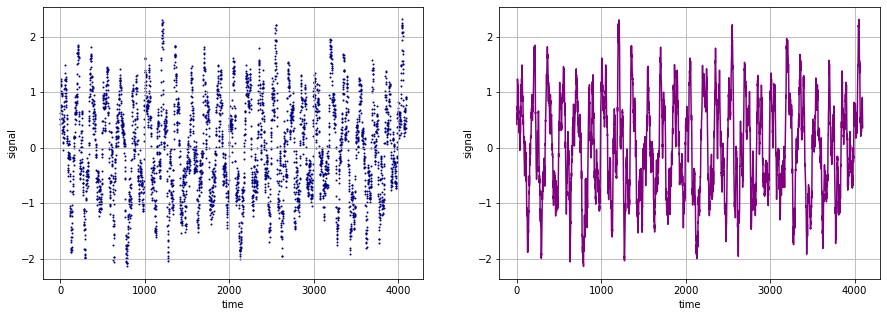

In [2]:
data = np.genfromtxt('assgn2.txt', delimiter='\t').T
time = data[0] *512
signal = data[1]

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].scatter(time, signal, c='darkblue', s=1)
axs[1].plot(time, signal, c='purple')

for ax in axs:
    ax.set_xlabel('time')
    ax.set_ylabel('signal')
    ax.grid(True)
plt.show()

# 2. Power spectrum

In [3]:
N = len(time)             ## number of points
Δt = time[1]-time[0]      ## timestep = how often signal is sampled
f_Nyq = 1/(2*Δt)          ## Nyquist frequency
f_Nyq

0.5

In [4]:
def get_power_spectrum(signal, N):
    
    signal_fft = fft(signal, norm = 'ortho')        ###  DFT  
    frequency = fftfreq(N, Δt)[:N//2]               ###  only non-negative frequenties

    power_spectrum = np.zeros(N//2)
    power_spectrum[0] = np.abs(signal_fft[0])**2
    power_spectrum[-1] = np.abs(signal_fft[N//2])**2
    for n in range(1, N//2):
        power_spectrum[n]= np.abs(signal_fft[n])**2 + np.abs(signal_fft[-n])**2
    
    return frequency, power_spectrum

In [5]:
frequency, power_spectrum = get_power_spectrum(signal, N)

### Power spectrum hand-crafted using fft

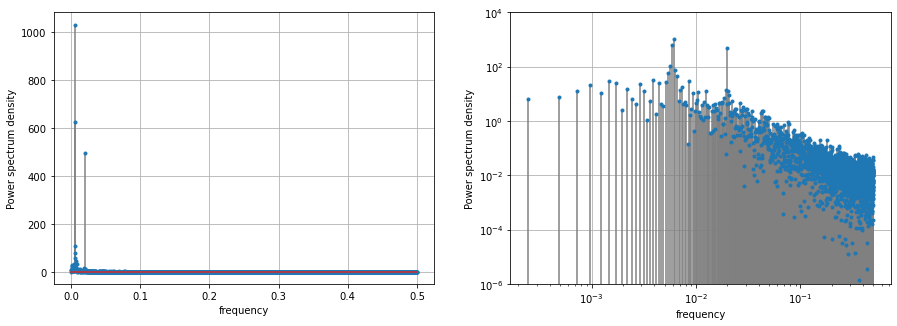

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].stem(frequency, power_spectrum, linefmt='grey', markerfmt='.')
axs[1].stem(frequency, power_spectrum, linefmt='grey', markerfmt='.')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[1].set_ylim(1e-6, 1e4)

for ax in axs:
    ax.set_xlabel('frequency')
    ax.set_ylabel('Power spectrum density')
    ax.grid(True)
    ax.set_ylim(1e-6, 1e4)

plt.show()

### Periodogram using SciPy library

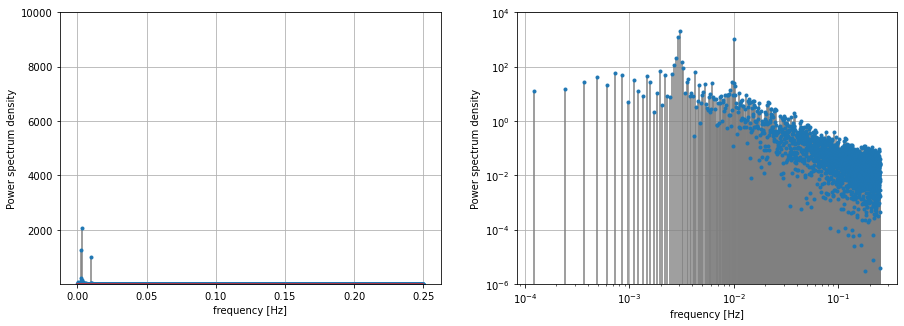

In [21]:
f, Pxx_den =  periodogram(signal, f_Nyq)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].stem(f, Pxx_den, linefmt='grey', markerfmt='.')
axs[1].stem(f, Pxx_den, linefmt='grey', markerfmt='.')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-10, 100)
for ax in axs:
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power spectrum density')
    ax.grid(True)
    ax.set_ylim(1e-6, 1e4)

plt.show()

# 3. Wiener filter

In [8]:
def noise_spectrum(f, f0, α, β):
    return α**2/(1 + β**2 - 2* β * np.cos(2 * π * f/f0 ) )

In [9]:
def Wiener_filter(frequency, power_spectrum, f0, α, β):
    
    noise = noise_spectrum(frequency, f0, α, β)
    Φ = ( power_spectrum - np.power(np.abs(noise), 2) ) / power_spectrum 
    Φ = np.where(Φ< 0, 0, Φ)
    
    return Φ

In [19]:
def visual_comparison(frequency, power_spectrum, N, f0, α, β):
    
    noise = noise_spectrum(frequency, f0, α, β) **2
    filetr = Wiener_filter(frequency, power_spectrum, f0, α, β)
    
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    axs[0].stem(frequency, power_spectrum, linefmt='grey', markerfmt='.', label = 'signal')
    axs[0].plot(frequency, noise, c='red', label = 'noise')
    axs[1].plot(frequency, filetr, c='red')

    axs[0].set_ylabel('Power spectrum density')
    axs[1].set_ylabel('Wiener filter')

    for ax in axs:
        ax.set_xlabel('frequency')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(1e-6, 1e4)
        ax.grid(True)
    plt.show()


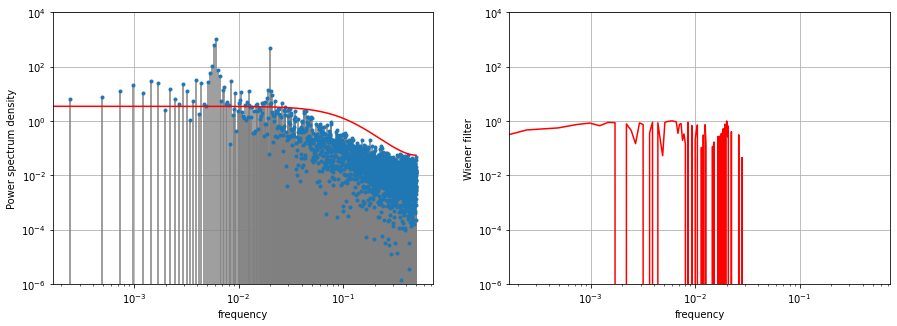

In [20]:
α = 1.5
β = 2.1
f0 = 1.0
visual_comparison(frequency, power_spectrum, N, f0, α, β)

### Restoring original signal using Wiener filter

C:\Users\Laptop\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


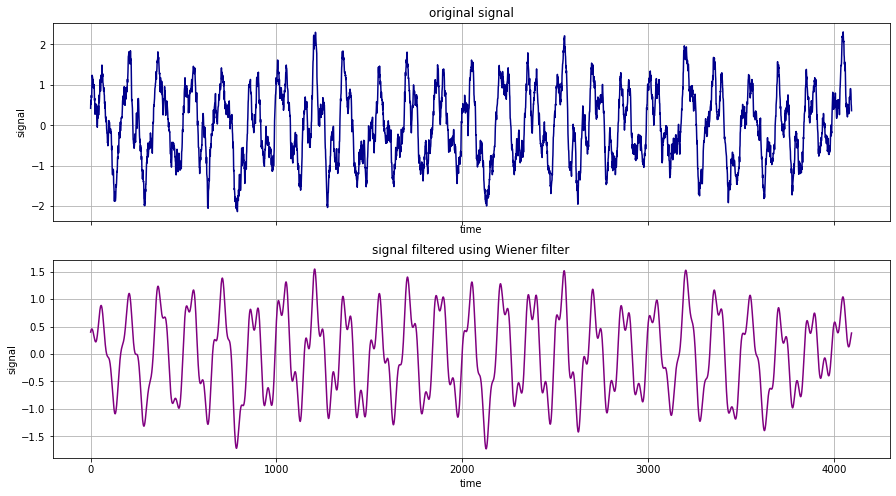

In [12]:
filtr = Wiener_filter(frequency, power_spectrum, f0, α, β)
filtr_extended = np.hstack((filtr, np.flip(filtr)))

signal_fft = fft(signal, norm = 'ortho')     
signal_filtred = ifft(signal_fft * filtr_extended, norm = 'ortho') 


fig, axs = plt.subplots(2, 1, figsize=(15,8), sharex = True)
axs[0].plot(time, signal, c='darkblue')
axs[1].plot(time, signal_filtred, c='purple')

axs[0].set_title("original signal")
axs[1].set_title("signal filtered using Wiener filter")

for ax in axs:
    ax.set_xlabel('time')
    ax.set_ylabel('signal')
    ax.grid(True)
plt.show()

In [13]:
frequency, power_spectrum_filtred = get_power_spectrum(signal_filtred, N)

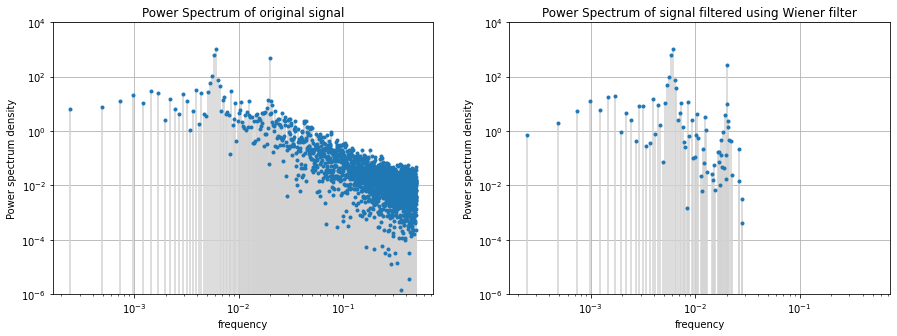

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].stem(frequency, power_spectrum, linefmt='lightgrey', markerfmt='.')
axs[1].stem(frequency, power_spectrum_filtred, linefmt='lightgrey', markerfmt='.')

axs[0].set_title("Power Spectrum of original signal")
axs[1].set_title("Power Spectrum of signal filtered using Wiener filter")


for ax in axs:
    ax.set_xlabel('frequency')
    ax.set_ylabel('Power spectrum density') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-6, 1e4)

    ax.grid(True)
plt.show()

## 4. The same, using  